# Can we use perplexity as a metric to detect AI generated text?

### Why this notebook?
With the rise of Generative AI in education, there is a growing need for teachers to check whether a text is written by a human or an AI. A possible metric to detect AI generated text is perplexity. In this notebook we will compare 5 AI generated texts with 5 human generated texts, calculate their perplexity and compare results.

### TL;DR
Yes, this works. (For the small set of given texts that is.)

### Contents
0. Install packages
1. Settings
2. Getting perplexity for 10 openAI generated texts
3. Getting the perplexity for 10 human written texts
4. Comparing results and conclusion

### Sources
The English human written text is from two articles:
- https://www.economist.com/europe/2023/06/09/ukraines-assault-in-zaporizhia-may-be-the-focus-of-its-offensive
- https://www.bbc.com/news/world-latin-america-65864158

The Dutch human written text is from these two sources:
- https://www.nu.nl/binnenland/6267525/hitteprotocol-rijkswaterstaat-geldt-ook-maandag-behalve-in-het-noorden.html
- https://nos.nl/artikel/2478434-het-oekraiense-tegenoffensief-is-begonnen-hoe-staat-het-ervoor

The AI generated text is from OpenAI GPT-3.5 using their API.

## Calculating perplexity

Perplexity is a metric that is used to measure the quality of language models. It is reversely related to the entropy of a model. 


- blog: https://medium.com/@priyankads/perplexity-of-language-models-41160427ed72
- wiki: https://en.wikipedia.org/wiki/Perplexity
- o'reilly: https://www.oreilly.com/library/view/natural-language-processing/9781787285101/ch21s05.html (to do)

## 0. Install packages

In [1]:
#pip install openai
#pip install transformers
#pip install torch

## 1. Settings

In [11]:
#set API keys
import os
import config
import torch
os.environ['OPENAI_API_KEY'] = config.openai_key # replace with your own API-key, but don't keep it in your source code :-)

In [3]:
#OpenAI settings
import openai  # for calling the OpenAI API

# models
EMBEDDING_MODEL = "text-embedding-ada-002" #choose your embeddings model
GPT_MODEL = "gpt-3.5-turbo" #choose the generative model

In [9]:
#Huggingface Transformers settings (to do perplexity) and 
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

## 2. Getting perplexity for 10 openAI generated texts

In [4]:
query_list = []
with open ('prompts_en.txt', mode='r') as prompts: #change to 'prompts_nl.txt' for Dutch prompts
    for prompt in prompts: #for each row do the following
        #query = prompt.split()
        query_list.append(prompt)
query_list

['What is a perceptron and what is a Multi Layered Percetpron?\n',
 'What is the difference between Machine Learning and Deep Learning\n',
 'Explain the backpropagation algorithm.\n',
 'Describe who Geoff Hinton is and what was his role in developing Neural Networks?\n',
 'How can we detect whether a text is written by a human or a generative AI?\n',
 'Describe the difference between human and artificial neurons\n',
 'In what way will generative AI transform the world\n',
 'Why was the language model BERT important for the field of NLP\n',
 "Explain why Meta's LLamA is better than GPT3.5?\n",
 'Explain what Gaussian Mixtures are.']

In [6]:
oa_result_list =[]
for i in range(len(query_list)):
    query = query_list[i]

    response = openai.ChatCompletion.create(
        messages=[
            {'role': 'system', 'content': ''},
            {'role': 'user', 'content': query},
        ],
        model=GPT_MODEL,
        temperature=0
        
        , #temperature is a parameter about the entropy of the model (the higher, the greater variation in results)
    )

    #print(response['choices'][0]['message']['content'])
    openai_result = response['choices'][0]['message']['content']
    oa_result_list.append(openai_result)

In [7]:
print(len(oa_result_list))
for i in range(len(oa_result_list)):
    print(oa_result_list[i])
    print(100*'-')

10
A perceptron is a type of artificial neural network that is used for binary classification tasks. It consists of a single layer of artificial neurons, also known as perceptrons, which take in multiple inputs and produce a single output. Each input is multiplied by a weight, and the weighted inputs are summed up. This sum is then passed through an activation function, which determines the output of the perceptron.

A multi-layered perceptron (MLP) is an extension of the perceptron that consists of multiple layers of artificial neurons. It is a feedforward neural network, meaning that information flows in one direction, from the input layer to the output layer. The input layer receives the input data, and the output layer produces the final output. The layers in between are called hidden layers, as their outputs are not directly observed.

In an MLP, each neuron in a layer is connected to every neuron in the subsequent layer. The connections between neurons have associated weights, wh

In [12]:
#getting the perplexity tensor for the openai generated text
perplexity_list =[]
for i in range(len(oa_result_list)):
    inputs_text = tokenizer(oa_result_list[i], return_tensors = "pt")
    loss = model(input_ids = inputs_text["input_ids"], labels = inputs_text["input_ids"]).loss
    ppl = torch.exp(loss)
    print(ppl)
    perplexity_list.append(ppl)

tensor(10.2043, grad_fn=<ExpBackward0>)
tensor(9.9168, grad_fn=<ExpBackward0>)
tensor(8.8854, grad_fn=<ExpBackward0>)
tensor(7.8319, grad_fn=<ExpBackward0>)
tensor(13.0384, grad_fn=<ExpBackward0>)
tensor(11.3414, grad_fn=<ExpBackward0>)
tensor(9.9246, grad_fn=<ExpBackward0>)
tensor(13.8144, grad_fn=<ExpBackward0>)
tensor(11.8843, grad_fn=<ExpBackward0>)
tensor(11.6865, grad_fn=<ExpBackward0>)


In [13]:
#converting tensors to string and getting just the values
ai_text_perplexity= []
for i in range(len(perplexity_list)):
    tensor_string=str(perplexity_list[i])
    a,b = tensor_string.split(",")
    tensor, perplexity = a.split("(")
    ai_text_perplexity.append(float(perplexity))
print(ai_text_perplexity)

[10.2043, 9.9168, 8.8854, 7.8319, 13.0384, 11.3414, 9.9246, 13.8144, 11.8843, 11.6865]


## 3. Getting the perplexity for 10 human written texts

In [14]:
query_list = []
with open ('humanwritten_en.txt', mode='r') as prompts: #change to 'humanwritten_nl.txt' if you prefer Dutch
    for prompt in prompts: #for each row do the following
        #query = prompt.split()
        query_list.append(prompt)
query_list

['Ukraine’s counter-offensive is just a few days old. But its shape is gradually becoming clearer. One axis points east, at the area around the bloodily contested town of Bakhmut and in Luhansk province. Another aims south and south-east from Vuhledar in Donetsk province. The third is perhaps the most important. On June 8th it became apparent that Ukraine had launched a major southward assault in Zaporizhia province, which forms the central part of the war’s long frontline. It looks like the biggest one yet.\n',
 'Although the attack began earlier, overnight on June 8th Ukrainian troops advanced in two prongs from Orikhiv, a small Ukrainian-held town, according to a source familiar with the course of fighting. One advance hugged the Konka river, a tributary of the Dnieper that snakes east of the town. The other occurred further east. Russian military bloggers on Telegram, a messaging platform, described a fierce assault with heavy artillery bombardment and the use of tanks.\n',
 'Russi

In [15]:
pp_list_human=[]
for i in range(len(query_list)):
    inputs_text = tokenizer(query_list[i], return_tensors = "pt")
    loss = model(input_ids = inputs_text["input_ids"], labels = inputs_text["input_ids"]).loss
    ppl = torch.exp(loss)
    print(ppl)
    pp_list_human.append(ppl)

tensor(35.6140, grad_fn=<ExpBackward0>)
tensor(39.4342, grad_fn=<ExpBackward0>)
tensor(41.6404, grad_fn=<ExpBackward0>)
tensor(42.4313, grad_fn=<ExpBackward0>)
tensor(34.4709, grad_fn=<ExpBackward0>)
tensor(33.6071, grad_fn=<ExpBackward0>)
tensor(44.7488, grad_fn=<ExpBackward0>)
tensor(23.9217, grad_fn=<ExpBackward0>)
tensor(32.5044, grad_fn=<ExpBackward0>)
tensor(38.8445, grad_fn=<ExpBackward0>)


In [16]:
human_text_perplexity= []
for i in range(len(pp_list_human)):
    tensor_string=str(pp_list_human[i])
    a,b = tensor_string.split(",")
    tensor, perplexity = a.split("(")
    print(float(perplexity))
    human_text_perplexity.append(float(perplexity))

35.614
39.4342
41.6404
42.4313
34.4709
33.6071
44.7488
23.9217
32.5044
38.8445


## 4. Comparing results and conclusion

In [17]:
#create one list
results =ai_text_perplexity+human_text_perplexity
print(results)
print(len(results))

[10.2043, 9.9168, 8.8854, 7.8319, 13.0384, 11.3414, 9.9246, 13.8144, 11.8843, 11.6865, 35.614, 39.4342, 41.6404, 42.4313, 34.4709, 33.6071, 44.7488, 23.9217, 32.5044, 38.8445]
20


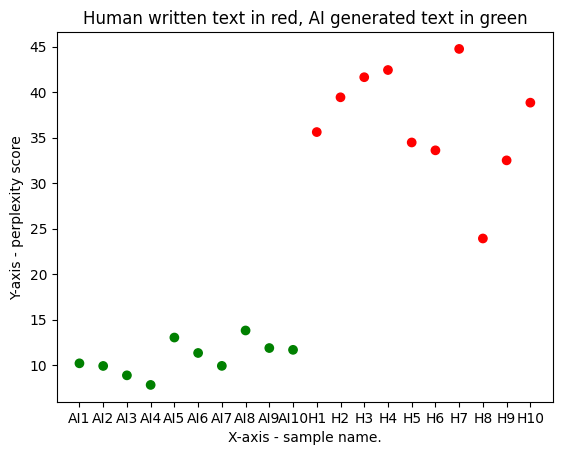

In [18]:
#create the plot
import matplotlib.pyplot as plt
x = ["AI1", "AI2", "AI3", "AI4", "AI5", "AI6","AI7","AI8","AI9","AI10", "H1","H2","H3","H4","H5","H6","H7","H8","H9","H10",]
y = results
colors = ['red' if value > 20 else 'green' for value in y]

# Create scatter plot
plt.scatter(x, y, c=colors)

# Customize plot
plt.title('Human written text in red, AI generated text in green')
plt.xlabel('X-axis - sample name.')
plt.ylabel('Y-axis - perplexity score')

# Display the plot
plt.show()

In this notebook we've compared 10 AI generated texts with 10 texts written by humans and calculated their perplexity. When we plotted the results we see a difference between AI-generated texts (low perplexity) and human written text (high perplexity). 

Without doubt, more testing is needed, especially with other types of text, to get more reliable results.